In [1]:
# 📦 1. Imports
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

2025-04-03 09:05:14.888285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A6000, compute capability 8.6


2025-04-03 09:05:15.718959: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-04-03 09:05:15.746886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-03 09:05:15.750045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.43GiB deviceMemoryBandwidth: 715.34GiB/s
2025-04-03 09:05:15.750059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-04-03 09:05:15.770381: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-04-03 09:05:15.770411: I tensorflow/stream_executor/platform/de

In [2]:
# 🔑 2. Open HDF5 File
hdf5_path = '/data/evmasuta/mag2ssfp/seg_dset.hdf5'  # Update this path to your HDF5 file
h5file = h5py.File(hdf5_path, "r")

train_data = h5file['training']      # shape (N, 256, 256, 8)
valid_data = h5file['validation']
test_data  = h5file['testing']

In [3]:
# 🔄 3. HDF5-Based tf.data.Dataset
def load_pair(index, source):
    img = source[index.numpy()]        # shape: (256, 256, 8)
    x = tf.convert_to_tensor(img[64:-64,64:-64, 1:2], dtype=tf.float32)  # input: channel 1 mag
    x_vel = tf.convert_to_tensor(img[64:-64,64:-64, 5:8], dtype=tf.float32)  # input: channel 5,6,7 velocity
    x = tf.concat([x, x_vel], axis=-1)
    
    y = tf.convert_to_tensor(img[64:-64,64:-64, 0:1], dtype=tf.float32)  # target: channel 0 ssfp

    return x, y

def get_dataset(source, batch_size=64, shuffle=True):
    indices = tf.data.Dataset.from_tensor_slices(tf.range(len(source)))
    
    def tf_wrapper(idx):
        return tf.py_function(func=lambda i: load_pair(i, source), inp=[idx], Tout=[tf.float32, tf.float32])
    
    ds = indices.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (tf.ensure_shape(x, [128, 128, 4]),
                              tf.ensure_shape(y, [128, 128, 1])))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = get_dataset(train_data)
valid_dataset = get_dataset(valid_data, shuffle=False)

2025-04-03 09:05:15.792803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 09:05:15.793446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-03 09:05:15.796168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.43GiB deviceMemoryBandwidth: 715.34GiB/s
2025-04-03 09:05:15.796212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but the

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=not apply_batchnorm))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[128, 128, 4])

    # Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (64x64)
        downsample(128, 4),  # (32x32)
        downsample(256, 4),  # (16x16)
        downsample(512, 4),  # (8x8)
        downsample(512, 4),  # (4x4)
        downsample(512, 4),  # (2x2)
#         downsample(64, 4, apply_batchnorm=False),  # (96x96)
#         downsample(128, 4),  # (48x48)
#         downsample(256, 4),  # (24x24)
#         downsample(512, 4),  # (12x12)
#         downsample(512, 4),  # (6x6)
#         downsample(512, 4),  # (3x3)
    ]

    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (4x4)
        upsample(512, 4, apply_dropout=True),  # (8x8)
        upsample(256, 4, apply_dropout=True),  # (16x16)
        upsample(128, 4),  # (32x32)
        upsample(64, 4),   # (64x64)
#         upsample(512, 4, apply_dropout=True),  # (6x6)
#         upsample(512, 4, apply_dropout=True),  # (12x12)
#         upsample(256, 4, apply_dropout=True),  # (24x24)
#         upsample(128, 4),  # (48x48)
#         upsample(64, 4),   # (96x96)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(1, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh', dtype='float32')  # (192x192x3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [5]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[128, 128, 1], name='input_image')
    tar = layers.Input(shape=[128, 128, 1], name='target_image')

    x = layers.Concatenate()([inp, tar])  # (128x128x6)

    down1 = downsample(64, 4, False)(x)   # (96x96x64)
    down2 = downsample(128, 4)(down1)     # (48x48x128)
    down3 = downsample(256, 4)(down2)     # (24x24x256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (26x26)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (23x23x512)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (25x25)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer, dtype='float32')(zero_pad2)  # (22x22x1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [6]:
"""
Myocardial segmentation loss
"""
def dice_loss(y_true, y_pred):
    smooth = tf.cast(1., dtype=tf.float32)

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Flatten across batch and spatial dims, keep channels
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)

    intersection = y_true_f * y_pred_f
    union = y_true_f + y_pred_f

    # Sum over pixels, keep channel dim
    intersection_sum = tf.reduce_sum(intersection, axis=1)
    union_sum = tf.reduce_sum(union, axis=1)

    dice = (2.0 * intersection_sum + smooth) / (union_sum + smooth)
    dice_loss = 1.0 - dice  # shape: (batch_size, channels)

    # Mean over channels and batch
    return tf.cast(tf.reduce_mean(dice_loss), dtype=tf.float16)

seg_unet = tf.keras.models.load_model("/data/evmasuta/mag2ssfp/myo_seg_128_sax_3ch.hdf5", custom_objects={"dice_loss":dice_loss})
seg_unet.trainable = False

def segmentation_consistency_loss(fake_output, real_output, epsilon = 1.0):
    seg_fake = seg_unet(fake_output, training=False)['outputs_images']
    seg_real = seg_unet(real_output, training=False)['outputs_images']
    # Flatten for Dice computation
    seg_fake_flat = tf.reshape(seg_fake, [seg_fake.shape[0], -1])
    seg_real_flat = tf.reshape(seg_real, [seg_real.shape[0], -1])

    intersection = tf.reduce_sum(seg_fake_flat * seg_real_flat, axis=1)
    denominator = tf.reduce_sum(seg_fake_flat, axis=1) + tf.reduce_sum(seg_real_flat, axis=1)

    dice_score = (2. * intersection + epsilon) / (denominator + epsilon)
    dice_loss = 1 - dice_score
    dice_loss = tf.clip_by_value(dice_loss, 0.0, 1.0)
    return tf.cast(tf.reduce_mean(dice_loss), dtype=tf.float32)
#     return tf.cast(tf.reduce_mean(tf.abs(seg_fake - seg_real)), dtype=tf.float32)  # Or Dice, SSIM, etc.

In [7]:
# 🧠 4. Build Generator and Discriminator

generator = Generator()
discriminator = Discriminator()

In [8]:
# ⚙️ 5. Loss Functions & Optimizers
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target, seg_weight=5.0):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    seg_loss = segmentation_consistency_loss(gen_output, target)
    gan_loss = tf.cast(gan_loss, tf.float32)
    l1_loss = tf.cast(l1_loss, tf.float32)
    seg_loss = tf.cast(seg_loss, tf.float32)
    total_gen_loss = gan_loss + (100 * l1_loss) + (seg_weight * seg_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_obj(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_obj(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

base_generator_optimizer = tf.keras.optimizers.Adam(3e-5, beta_1=0.5)
base_discriminator_optimizer = tf.keras.optimizers.Adam(3e-5, beta_1=0.5)

gen_optimizer = mixed_precision.LossScaleOptimizer(base_generator_optimizer)
disc_optimizer = mixed_precision.LossScaleOptimizer(base_discriminator_optimizer)

In [9]:
# 🔁 6. Training Step
@tf.function
def train_step(input_image, target):
    # Extract the magnitude channel (assuming it's channel 0)
    mag_only = input_image[..., :1]
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([mag_only, target], training=True)
        disc_generated_output = discriminator([mag_only, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Scale the losses
        scaled_gen_loss = gen_optimizer.get_scaled_loss(gen_loss)
        scaled_disc_loss = disc_optimizer.get_scaled_loss(disc_loss)

    # Compute gradients
    scaled_gen_grads = gen_tape.gradient(scaled_gen_loss, generator.trainable_variables)
    scaled_disc_grads = disc_tape.gradient(scaled_disc_loss, discriminator.trainable_variables)

    # Unscale them
    gen_grads = gen_optimizer.get_unscaled_gradients(scaled_gen_grads)
    disc_grads = disc_optimizer.get_unscaled_gradients(scaled_disc_grads)

    # Apply gradients
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
#     return gen_loss, disc_loss
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss)

In [10]:
def evaluate_dice_ssim(generator, val_dataset, seg_model, alpha=0.5):
    total_dice = 0.0
    total_ssim = 0.0
    count = 0

    for input_image, target in val_dataset:
        prediction = generator(input_image, training=False)

        # --- Dice score via seg_unet ---
        seg_pred = seg_model(prediction, training=False)
        seg_target = seg_model(target, training=False)

        if isinstance(seg_pred, dict):   seg_pred = list(seg_pred.values())[0]
        if isinstance(seg_target, dict): seg_target = list(seg_target.values())[0]
        pred_flat = tf.reshape(seg_pred, [seg_pred.shape[0], -1])
        target_flat = tf.reshape(seg_target, [seg_target.shape[0], -1])
        intersection = tf.reduce_sum(pred_flat * target_flat, axis=1)
        denominator = tf.reduce_sum(pred_flat, axis=1) + tf.reduce_sum(target_flat, axis=1)
        dice_score = (2. * intersection + 1.) / (denominator + 1.)
        total_dice += tf.reduce_sum(dice_score) # <-- reduce mean for multichannel segmentation

        # --- SSIM score ---
        ssim_score = tf.image.ssim(prediction, target, max_val=1.0)  # Inputs in [-1, 1], range = 2
        total_ssim += tf.reduce_sum(ssim_score)

        count += prediction.shape[0]

    avg_dice = tf.cast(total_dice / count, dtype=tf.float32)
    avg_ssim = tf.cast(total_ssim / count, dtype=tf.float32)
    composite = alpha * avg_dice + (1 - alpha) * avg_ssim

    return avg_dice, avg_ssim, composite

In [11]:
# import time
# from IPython.display import clear_output

# def generate_and_show_sample(generator, dataset, num=3):
#     for input_image, target in dataset.take(num):
#         prediction = generator(input_image, training=False)
        
#         plt.figure(figsize=(12, 4))
#         titles = ["Input (Ch.1)", "Target (Ch.0)", "Generated"]
#         for i, img in enumerate([input_image[0], target[0], prediction[0]]):
#             plt.subplot(1, 3, i + 1)
#             plt.imshow(img[..., 0], cmap='gray')
#             plt.title(titles[i])
#             plt.axis('off')
#         plt.show()

In [12]:
def generate_and_save_sample(generator, dataset, seg_model, save_dir, epoch, num=3):
    os.makedirs(save_dir, exist_ok=True)

    titles = ["Input (Ch.1)", "Generated", "Target (Ch.0)"]
    seg_titles = ["Seg(Input)", "Seg(Generated)", "Seg(Target)"]

    fig, axs = plt.subplots(2 * num, 3, figsize=(12, 4 * num))  # 2 rows per sample

    for idx, (input_image, target) in enumerate(dataset.take(num)):
        mag_only = input_image[..., :1]
        prediction = generator(input_image, training=False)

        # Run all images through the frozen segmentation model
        seg_input = seg_model(mag_only, training=False)
        seg_target = seg_model(target, training=False)
        seg_pred = seg_model(prediction, training=False)

        # Handle dict outputs
        if isinstance(seg_input, dict):  seg_input = list(seg_input.values())[0]
        if isinstance(seg_target, dict): seg_target = list(seg_target.values())[0]
        if isinstance(seg_pred, dict):   seg_pred = list(seg_pred.values())[0]

        images = [mag_only[0], prediction[0], target[0]]
        segs = [seg_input[0][..., 1], seg_pred[0][..., 1], seg_target[0][..., 1]]

        # Plot top row: input, generated, target
        for i in range(3):
            ax = axs[2 * idx][i] if num > 1 else axs[2 * idx + 0, i]
            ax.imshow(tf.squeeze(images[i]), cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')

        # Plot bottom row: seg(input), seg(pred), seg(target)
        for i in range(3):
            ax = axs[2 * idx + 1][i] if num > 1 else axs[2 * idx + 1, i]
            ax.imshow(tf.squeeze(segs[i]), cmap='gray')
            ax.set_title(seg_titles[i])
            ax.axis('off')

    plt.tight_layout()
    filename = os.path.join(save_dir, f"epoch_{epoch:03d}.png")
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()

In [13]:
import os
checkpoint_dir = "checkpoints_mag2ssfp_pix2pix"
os.makedirs(checkpoint_dir, exist_ok=True)

best_dice = 0.0  # Higher is better
best_composite_score = 0.0

In [14]:
# 🏃 7. Training Loop
from tqdm import tqdm
EPOCHS = 200
EARLY_STOPPING_PATIENCE = 40

print(f"🔥 Starting training for up to {EPOCHS} epochs with early stopping after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")

import datetime

log_dir = "logs/pix2pix/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary_writer = tf.summary.create_file_writer(log_dir + "/train")
val_summary_writer   = tf.summary.create_file_writer(log_dir + "/val")


%load_ext tensorboard
%tensorboard --logdir logs/pix2pix --port 8111

for epoch in range(EPOCHS):
    print(f"\n🌀 Epoch {epoch + 1}/{EPOCHS}")
    step_bar = tqdm(train_dataset, desc="Training", leave=False)
    
    for input_image, target in step_bar:
        gen_loss, disc_loss = train_step(input_image, target)
        step_bar.set_postfix({"G Loss": float(gen_loss), "D Loss": float(disc_loss)})

    # 📊 Evaluate validation
    avg_dice, avg_ssim, composite = evaluate_dice_ssim(generator, valid_dataset, seg_unet, alpha=0.5)
    print(f"📏 Dice: {avg_dice:.4f} | SSIM: {avg_ssim:.4f} | Composite: {composite:.4f}")

    # 💾 Save if composite improves
    if composite > best_composite_score:
        best_composite_score = composite
        epochs_since_improvement = 0
        save_path = os.path.join(checkpoint_dir, f"generator_best_composite_epoch_{epoch+1}.h5")
        generator.save(save_path)
        print(f"✅ Saved best generator (composite: {composite:.4f}) to {save_path}")
    else:
        epochs_since_improvement += 1
        print(f"📉 No improvement for {epochs_since_improvement} epoch(s)")

    # 🛑 Early stopping
    if epochs_since_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"🛑 Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs without improvement.")
        break

    # 📊 Show a sample output at the end of each epoch
    generate_and_save_sample(generator, valid_dataset, seg_unet, '{}_epoch_viz/'.format('mag2ssfp_pix2pix'), epoch=epoch, num=7)
    # Log training losses
    with train_summary_writer.as_default():
        tf.summary.scalar("Generator Loss", gen_loss, step=epoch)
        tf.summary.scalar("Discriminator Loss", disc_loss, step=epoch)

    # Log validation metrics
    with val_summary_writer.as_default():
        tf.summary.scalar("Validation Dice", avg_dice, step=epoch)
        tf.summary.scalar("Validation SSIM", avg_ssim, step=epoch)
        tf.summary.scalar("Validation Composite Score", composite, step=epoch)

🔥 Starting training for up to 200 epochs with early stopping after 40 epochs of no improvement.



🌀 Epoch 1/200


Training:   0%|                                                                                                                                                                                                      | 0/236 [00:00<?, ?it/s]2025-04-03 09:05:18.999956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-03 09:05:19.000274: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3792685000 Hz
2025-04-03 09:05:22.183046: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-04-03 09:05:22.212988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8907
2025-04-03 09:05:22.254492: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-03 09:05:22.254515: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas

📏 Dice: 0.6719 | SSIM: 0.4559 | Composite: 0.5639
✅ Saved best generator (composite: 0.5639) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_1.h5

🌀 Epoch 2/200


📏 Dice: 0.7856 | SSIM: 0.4277 | Composite: 0.6067
✅ Saved best generator (composite: 0.6067) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_2.h5

🌀 Epoch 3/200


📏 Dice: 0.8276 | SSIM: 0.4962 | Composite: 0.6619
✅ Saved best generator (composite: 0.6619) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_3.h5

🌀 Epoch 4/200


📏 Dice: 0.8613 | SSIM: 0.4801 | Composite: 0.6707
✅ Saved best generator (composite: 0.6707) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_4.h5

🌀 Epoch 5/200


📏 Dice: 0.8638 | SSIM: 0.4880 | Composite: 0.6759
✅ Saved best generator (composite: 0.6759) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_5.h5

🌀 Epoch 6/200


📏 Dice: 0.8657 | SSIM: 0.5018 | Composite: 0.6838
✅ Saved best generator (composite: 0.6838) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_6.h5

🌀 Epoch 7/200


📏 Dice: 0.8618 | SSIM: 0.5003 | Composite: 0.6811
📉 No improvement for 1 epoch(s)

🌀 Epoch 8/200


📏 Dice: 0.8584 | SSIM: 0.5176 | Composite: 0.6880
✅ Saved best generator (composite: 0.6880) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_8.h5

🌀 Epoch 9/200


📏 Dice: 0.8647 | SSIM: 0.5259 | Composite: 0.6953
✅ Saved best generator (composite: 0.6953) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_9.h5

🌀 Epoch 10/200


📏 Dice: 0.8657 | SSIM: 0.5127 | Composite: 0.6892
📉 No improvement for 1 epoch(s)

🌀 Epoch 11/200


📏 Dice: 0.8623 | SSIM: 0.5379 | Composite: 0.7001
✅ Saved best generator (composite: 0.7001) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_11.h5

🌀 Epoch 12/200


📏 Dice: 0.8623 | SSIM: 0.5349 | Composite: 0.6986
📉 No improvement for 1 epoch(s)

🌀 Epoch 13/200


📏 Dice: 0.8716 | SSIM: 0.5292 | Composite: 0.7004
✅ Saved best generator (composite: 0.7004) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_13.h5

🌀 Epoch 14/200


📏 Dice: 0.8613 | SSIM: 0.5471 | Composite: 0.7042
✅ Saved best generator (composite: 0.7042) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_14.h5

🌀 Epoch 15/200


📏 Dice: 0.8628 | SSIM: 0.5376 | Composite: 0.7002
📉 No improvement for 1 epoch(s)

🌀 Epoch 16/200


📏 Dice: 0.8628 | SSIM: 0.5394 | Composite: 0.7011
📉 No improvement for 2 epoch(s)

🌀 Epoch 17/200


📏 Dice: 0.8594 | SSIM: 0.5279 | Composite: 0.6937
📉 No improvement for 3 epoch(s)

🌀 Epoch 18/200


📏 Dice: 0.8682 | SSIM: 0.5458 | Composite: 0.7070
✅ Saved best generator (composite: 0.7070) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_18.h5

🌀 Epoch 19/200


📏 Dice: 0.8667 | SSIM: 0.5373 | Composite: 0.7020
📉 No improvement for 1 epoch(s)

🌀 Epoch 20/200


📏 Dice: 0.8652 | SSIM: 0.5414 | Composite: 0.7033
📉 No improvement for 2 epoch(s)

🌀 Epoch 21/200


📏 Dice: 0.8696 | SSIM: 0.5300 | Composite: 0.6998
📉 No improvement for 3 epoch(s)

🌀 Epoch 22/200


📏 Dice: 0.8730 | SSIM: 0.5416 | Composite: 0.7073
✅ Saved best generator (composite: 0.7073) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_22.h5

🌀 Epoch 23/200


📏 Dice: 0.8667 | SSIM: 0.5390 | Composite: 0.7029
📉 No improvement for 1 epoch(s)

🌀 Epoch 24/200


📏 Dice: 0.8687 | SSIM: 0.5405 | Composite: 0.7046
📉 No improvement for 2 epoch(s)

🌀 Epoch 25/200


📏 Dice: 0.8730 | SSIM: 0.5203 | Composite: 0.6967
📉 No improvement for 3 epoch(s)

🌀 Epoch 26/200


📏 Dice: 0.8687 | SSIM: 0.5438 | Composite: 0.7062
📉 No improvement for 4 epoch(s)

🌀 Epoch 27/200


📏 Dice: 0.8696 | SSIM: 0.5199 | Composite: 0.6948
📉 No improvement for 5 epoch(s)

🌀 Epoch 28/200


📏 Dice: 0.8682 | SSIM: 0.5261 | Composite: 0.6971
📉 No improvement for 6 epoch(s)

🌀 Epoch 29/200


📏 Dice: 0.8672 | SSIM: 0.5427 | Composite: 0.7049
📉 No improvement for 7 epoch(s)

🌀 Epoch 30/200


📏 Dice: 0.8672 | SSIM: 0.5258 | Composite: 0.6965
📉 No improvement for 8 epoch(s)

🌀 Epoch 31/200


📏 Dice: 0.8711 | SSIM: 0.5394 | Composite: 0.7052
📉 No improvement for 9 epoch(s)

🌀 Epoch 32/200


📏 Dice: 0.8682 | SSIM: 0.5375 | Composite: 0.7028
📉 No improvement for 10 epoch(s)

🌀 Epoch 33/200


📏 Dice: 0.8726 | SSIM: 0.5280 | Composite: 0.7003
📉 No improvement for 11 epoch(s)

🌀 Epoch 34/200


📏 Dice: 0.8730 | SSIM: 0.5272 | Composite: 0.7001
📉 No improvement for 12 epoch(s)

🌀 Epoch 35/200


📏 Dice: 0.8735 | SSIM: 0.5377 | Composite: 0.7056
📉 No improvement for 13 epoch(s)

🌀 Epoch 36/200


📏 Dice: 0.8682 | SSIM: 0.5320 | Composite: 0.7001
📉 No improvement for 14 epoch(s)

🌀 Epoch 37/200


📏 Dice: 0.8711 | SSIM: 0.5382 | Composite: 0.7046
📉 No improvement for 15 epoch(s)

🌀 Epoch 38/200


📏 Dice: 0.8716 | SSIM: 0.5339 | Composite: 0.7028
📉 No improvement for 16 epoch(s)

🌀 Epoch 39/200


📏 Dice: 0.8706 | SSIM: 0.5406 | Composite: 0.7056
📉 No improvement for 17 epoch(s)

🌀 Epoch 40/200


📏 Dice: 0.8706 | SSIM: 0.5339 | Composite: 0.7023
📉 No improvement for 18 epoch(s)

🌀 Epoch 41/200


📏 Dice: 0.8716 | SSIM: 0.5425 | Composite: 0.7071
📉 No improvement for 19 epoch(s)

🌀 Epoch 42/200


📏 Dice: 0.8735 | SSIM: 0.5463 | Composite: 0.7099
✅ Saved best generator (composite: 0.7099) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_42.h5

🌀 Epoch 43/200


📏 Dice: 0.8711 | SSIM: 0.5498 | Composite: 0.7104
✅ Saved best generator (composite: 0.7104) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_43.h5

🌀 Epoch 44/200


📏 Dice: 0.8657 | SSIM: 0.5587 | Composite: 0.7122
✅ Saved best generator (composite: 0.7122) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_44.h5

🌀 Epoch 45/200


📏 Dice: 0.8770 | SSIM: 0.5417 | Composite: 0.7093
📉 No improvement for 1 epoch(s)

🌀 Epoch 46/200


📏 Dice: 0.8726 | SSIM: 0.5549 | Composite: 0.7138
✅ Saved best generator (composite: 0.7138) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_46.h5

🌀 Epoch 47/200


📏 Dice: 0.8760 | SSIM: 0.5467 | Composite: 0.7113
📉 No improvement for 1 epoch(s)

🌀 Epoch 48/200


📏 Dice: 0.8740 | SSIM: 0.5454 | Composite: 0.7097
📉 No improvement for 2 epoch(s)

🌀 Epoch 49/200


📏 Dice: 0.8716 | SSIM: 0.5451 | Composite: 0.7084
📉 No improvement for 3 epoch(s)

🌀 Epoch 50/200


📏 Dice: 0.8735 | SSIM: 0.5512 | Composite: 0.7124
📉 No improvement for 4 epoch(s)

🌀 Epoch 51/200


📏 Dice: 0.8774 | SSIM: 0.5505 | Composite: 0.7140
✅ Saved best generator (composite: 0.7140) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_51.h5

🌀 Epoch 52/200


📏 Dice: 0.8730 | SSIM: 0.5529 | Composite: 0.7129
📉 No improvement for 1 epoch(s)

🌀 Epoch 53/200


📏 Dice: 0.8735 | SSIM: 0.5460 | Composite: 0.7098
📉 No improvement for 2 epoch(s)

🌀 Epoch 54/200


📏 Dice: 0.8760 | SSIM: 0.5443 | Composite: 0.7102
📉 No improvement for 3 epoch(s)

🌀 Epoch 55/200


📏 Dice: 0.8745 | SSIM: 0.5565 | Composite: 0.7155
✅ Saved best generator (composite: 0.7155) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_55.h5

🌀 Epoch 56/200


📏 Dice: 0.8774 | SSIM: 0.5466 | Composite: 0.7120
📉 No improvement for 1 epoch(s)

🌀 Epoch 57/200


📏 Dice: 0.8789 | SSIM: 0.5536 | Composite: 0.7163
✅ Saved best generator (composite: 0.7163) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_57.h5

🌀 Epoch 58/200


📏 Dice: 0.8755 | SSIM: 0.5467 | Composite: 0.7111
📉 No improvement for 1 epoch(s)

🌀 Epoch 59/200


📏 Dice: 0.8770 | SSIM: 0.5478 | Composite: 0.7124
📉 No improvement for 2 epoch(s)

🌀 Epoch 60/200


📏 Dice: 0.8765 | SSIM: 0.5455 | Composite: 0.7110
📉 No improvement for 3 epoch(s)

🌀 Epoch 61/200


📏 Dice: 0.8755 | SSIM: 0.5531 | Composite: 0.7143
📉 No improvement for 4 epoch(s)

🌀 Epoch 62/200


📏 Dice: 0.8794 | SSIM: 0.5511 | Composite: 0.7153
📉 No improvement for 5 epoch(s)

🌀 Epoch 63/200


📏 Dice: 0.8774 | SSIM: 0.5534 | Composite: 0.7154
📉 No improvement for 6 epoch(s)

🌀 Epoch 64/200


📏 Dice: 0.8784 | SSIM: 0.5453 | Composite: 0.7119
📉 No improvement for 7 epoch(s)

🌀 Epoch 65/200


📏 Dice: 0.8774 | SSIM: 0.5507 | Composite: 0.7140
📉 No improvement for 8 epoch(s)

🌀 Epoch 66/200


📏 Dice: 0.8799 | SSIM: 0.5548 | Composite: 0.7173
✅ Saved best generator (composite: 0.7173) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_66.h5

🌀 Epoch 67/200


📏 Dice: 0.8789 | SSIM: 0.5453 | Composite: 0.7121
📉 No improvement for 1 epoch(s)

🌀 Epoch 68/200


📏 Dice: 0.8794 | SSIM: 0.5535 | Composite: 0.7164
📉 No improvement for 2 epoch(s)

🌀 Epoch 69/200


📏 Dice: 0.8770 | SSIM: 0.5456 | Composite: 0.7113
📉 No improvement for 3 epoch(s)

🌀 Epoch 70/200


📏 Dice: 0.8789 | SSIM: 0.5537 | Composite: 0.7163
📉 No improvement for 4 epoch(s)

🌀 Epoch 71/200


📏 Dice: 0.8770 | SSIM: 0.5432 | Composite: 0.7101
📉 No improvement for 5 epoch(s)

🌀 Epoch 72/200


📏 Dice: 0.8774 | SSIM: 0.5495 | Composite: 0.7135
📉 No improvement for 6 epoch(s)

🌀 Epoch 73/200


📏 Dice: 0.8726 | SSIM: 0.5457 | Composite: 0.7092
📉 No improvement for 7 epoch(s)

🌀 Epoch 74/200


📏 Dice: 0.8745 | SSIM: 0.5598 | Composite: 0.7172
📉 No improvement for 8 epoch(s)

🌀 Epoch 75/200


📏 Dice: 0.8765 | SSIM: 0.5560 | Composite: 0.7162
📉 No improvement for 9 epoch(s)

🌀 Epoch 76/200


📏 Dice: 0.8774 | SSIM: 0.5577 | Composite: 0.7176
✅ Saved best generator (composite: 0.7176) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_76.h5

🌀 Epoch 77/200


📏 Dice: 0.8794 | SSIM: 0.5594 | Composite: 0.7194
✅ Saved best generator (composite: 0.7194) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_77.h5

🌀 Epoch 78/200


📏 Dice: 0.8794 | SSIM: 0.5541 | Composite: 0.7167
📉 No improvement for 1 epoch(s)

🌀 Epoch 79/200


📏 Dice: 0.8770 | SSIM: 0.5520 | Composite: 0.7145
📉 No improvement for 2 epoch(s)

🌀 Epoch 80/200


📏 Dice: 0.8774 | SSIM: 0.5440 | Composite: 0.7107
📉 No improvement for 3 epoch(s)

🌀 Epoch 81/200


📏 Dice: 0.8765 | SSIM: 0.5554 | Composite: 0.7159
📉 No improvement for 4 epoch(s)

🌀 Epoch 82/200


📏 Dice: 0.8765 | SSIM: 0.5577 | Composite: 0.7171
📉 No improvement for 5 epoch(s)

🌀 Epoch 83/200


📏 Dice: 0.8770 | SSIM: 0.5494 | Composite: 0.7132
📉 No improvement for 6 epoch(s)

🌀 Epoch 84/200


📏 Dice: 0.8760 | SSIM: 0.5529 | Composite: 0.7144
📉 No improvement for 7 epoch(s)

🌀 Epoch 85/200


📏 Dice: 0.8735 | SSIM: 0.5543 | Composite: 0.7139
📉 No improvement for 8 epoch(s)

🌀 Epoch 86/200


📏 Dice: 0.8784 | SSIM: 0.5596 | Composite: 0.7190
📉 No improvement for 9 epoch(s)

🌀 Epoch 87/200


📏 Dice: 0.8740 | SSIM: 0.5580 | Composite: 0.7160
📉 No improvement for 10 epoch(s)

🌀 Epoch 88/200


📏 Dice: 0.8774 | SSIM: 0.5467 | Composite: 0.7120
📉 No improvement for 11 epoch(s)

🌀 Epoch 89/200


📏 Dice: 0.8784 | SSIM: 0.5527 | Composite: 0.7156
📉 No improvement for 12 epoch(s)

🌀 Epoch 90/200


📏 Dice: 0.8784 | SSIM: 0.5484 | Composite: 0.7134
📉 No improvement for 13 epoch(s)

🌀 Epoch 91/200


📏 Dice: 0.8765 | SSIM: 0.5535 | Composite: 0.7150
📉 No improvement for 14 epoch(s)

🌀 Epoch 92/200


📏 Dice: 0.8770 | SSIM: 0.5563 | Composite: 0.7166
📉 No improvement for 15 epoch(s)

🌀 Epoch 93/200


📏 Dice: 0.8774 | SSIM: 0.5547 | Composite: 0.7161
📉 No improvement for 16 epoch(s)

🌀 Epoch 94/200


📏 Dice: 0.8799 | SSIM: 0.5645 | Composite: 0.7222
✅ Saved best generator (composite: 0.7222) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_94.h5

🌀 Epoch 95/200


📏 Dice: 0.8726 | SSIM: 0.5615 | Composite: 0.7170
📉 No improvement for 1 epoch(s)

🌀 Epoch 96/200


📏 Dice: 0.8726 | SSIM: 0.5573 | Composite: 0.7149
📉 No improvement for 2 epoch(s)

🌀 Epoch 97/200


📏 Dice: 0.8765 | SSIM: 0.5609 | Composite: 0.7187
📉 No improvement for 3 epoch(s)

🌀 Epoch 98/200


📏 Dice: 0.8726 | SSIM: 0.5605 | Composite: 0.7165
📉 No improvement for 4 epoch(s)

🌀 Epoch 99/200


📏 Dice: 0.8745 | SSIM: 0.5610 | Composite: 0.7178
📉 No improvement for 5 epoch(s)

🌀 Epoch 100/200


📏 Dice: 0.8735 | SSIM: 0.5543 | Composite: 0.7139
📉 No improvement for 6 epoch(s)

🌀 Epoch 101/200


📏 Dice: 0.8774 | SSIM: 0.5601 | Composite: 0.7188
📉 No improvement for 7 epoch(s)

🌀 Epoch 102/200


📏 Dice: 0.8755 | SSIM: 0.5604 | Composite: 0.7180
📉 No improvement for 8 epoch(s)

🌀 Epoch 103/200


📏 Dice: 0.8755 | SSIM: 0.5683 | Composite: 0.7219
📉 No improvement for 9 epoch(s)

🌀 Epoch 104/200


📏 Dice: 0.8789 | SSIM: 0.5663 | Composite: 0.7226
✅ Saved best generator (composite: 0.7226) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_104.h5

🌀 Epoch 105/200


📏 Dice: 0.8755 | SSIM: 0.5681 | Composite: 0.7218
📉 No improvement for 1 epoch(s)

🌀 Epoch 106/200


📏 Dice: 0.8726 | SSIM: 0.5713 | Composite: 0.7219
📉 No improvement for 2 epoch(s)

🌀 Epoch 107/200


📏 Dice: 0.8745 | SSIM: 0.5677 | Composite: 0.7211
📉 No improvement for 3 epoch(s)

🌀 Epoch 108/200


📏 Dice: 0.8770 | SSIM: 0.5658 | Composite: 0.7214
📉 No improvement for 4 epoch(s)

🌀 Epoch 109/200


📏 Dice: 0.8735 | SSIM: 0.5704 | Composite: 0.7220
📉 No improvement for 5 epoch(s)

🌀 Epoch 110/200


📏 Dice: 0.8784 | SSIM: 0.5638 | Composite: 0.7211
📉 No improvement for 6 epoch(s)

🌀 Epoch 111/200


📏 Dice: 0.8789 | SSIM: 0.5734 | Composite: 0.7261
✅ Saved best generator (composite: 0.7261) to checkpoints_mag2ssfp_pix2pix/generator_best_composite_epoch_111.h5

🌀 Epoch 112/200


📏 Dice: 0.8760 | SSIM: 0.5698 | Composite: 0.7229
📉 No improvement for 1 epoch(s)

🌀 Epoch 113/200


📏 Dice: 0.8745 | SSIM: 0.5658 | Composite: 0.7202
📉 No improvement for 2 epoch(s)

🌀 Epoch 114/200


📏 Dice: 0.8755 | SSIM: 0.5652 | Composite: 0.7203
📉 No improvement for 3 epoch(s)

🌀 Epoch 115/200


📏 Dice: 0.8765 | SSIM: 0.5689 | Composite: 0.7227
📉 No improvement for 4 epoch(s)

🌀 Epoch 116/200


📏 Dice: 0.8755 | SSIM: 0.5725 | Composite: 0.7240
📉 No improvement for 5 epoch(s)

🌀 Epoch 117/200


📏 Dice: 0.8789 | SSIM: 0.5631 | Composite: 0.7210
📉 No improvement for 6 epoch(s)

🌀 Epoch 118/200


📏 Dice: 0.8755 | SSIM: 0.5735 | Composite: 0.7245
📉 No improvement for 7 epoch(s)

🌀 Epoch 119/200


📏 Dice: 0.8740 | SSIM: 0.5649 | Composite: 0.7195
📉 No improvement for 8 epoch(s)

🌀 Epoch 120/200


📏 Dice: 0.8745 | SSIM: 0.5735 | Composite: 0.7240
📉 No improvement for 9 epoch(s)

🌀 Epoch 121/200


📏 Dice: 0.8774 | SSIM: 0.5653 | Composite: 0.7214
📉 No improvement for 10 epoch(s)

🌀 Epoch 122/200


📏 Dice: 0.8745 | SSIM: 0.5684 | Composite: 0.7214
📉 No improvement for 11 epoch(s)

🌀 Epoch 123/200


📏 Dice: 0.8726 | SSIM: 0.5640 | Composite: 0.7183
📉 No improvement for 12 epoch(s)

🌀 Epoch 124/200


📏 Dice: 0.8765 | SSIM: 0.5723 | Composite: 0.7244
📉 No improvement for 13 epoch(s)

🌀 Epoch 125/200


📏 Dice: 0.8760 | SSIM: 0.5644 | Composite: 0.7202
📉 No improvement for 14 epoch(s)

🌀 Epoch 126/200


📏 Dice: 0.8765 | SSIM: 0.5673 | Composite: 0.7219
📉 No improvement for 15 epoch(s)

🌀 Epoch 127/200


📏 Dice: 0.8774 | SSIM: 0.5681 | Composite: 0.7228
📉 No improvement for 16 epoch(s)

🌀 Epoch 128/200


📏 Dice: 0.8770 | SSIM: 0.5711 | Composite: 0.7240
📉 No improvement for 17 epoch(s)

🌀 Epoch 129/200


📏 Dice: 0.8765 | SSIM: 0.5699 | Composite: 0.7232
📉 No improvement for 18 epoch(s)

🌀 Epoch 130/200


📏 Dice: 0.8755 | SSIM: 0.5638 | Composite: 0.7196
📉 No improvement for 19 epoch(s)

🌀 Epoch 131/200


📏 Dice: 0.8682 | SSIM: 0.5734 | Composite: 0.7208
📉 No improvement for 20 epoch(s)

🌀 Epoch 132/200


📏 Dice: 0.8735 | SSIM: 0.5760 | Composite: 0.7248
📉 No improvement for 21 epoch(s)

🌀 Epoch 133/200


📏 Dice: 0.8765 | SSIM: 0.5699 | Composite: 0.7232
📉 No improvement for 22 epoch(s)

🌀 Epoch 134/200


📏 Dice: 0.8755 | SSIM: 0.5715 | Composite: 0.7235
📉 No improvement for 23 epoch(s)

🌀 Epoch 135/200


📏 Dice: 0.8765 | SSIM: 0.5697 | Composite: 0.7231
📉 No improvement for 24 epoch(s)

🌀 Epoch 136/200


📏 Dice: 0.8770 | SSIM: 0.5673 | Composite: 0.7221
📉 No improvement for 25 epoch(s)

🌀 Epoch 137/200


📏 Dice: 0.8774 | SSIM: 0.5710 | Composite: 0.7242
📉 No improvement for 26 epoch(s)

🌀 Epoch 138/200


📏 Dice: 0.8760 | SSIM: 0.5701 | Composite: 0.7230
📉 No improvement for 27 epoch(s)

🌀 Epoch 139/200


📏 Dice: 0.8784 | SSIM: 0.5736 | Composite: 0.7260
📉 No improvement for 28 epoch(s)

🌀 Epoch 140/200


📏 Dice: 0.8760 | SSIM: 0.5670 | Composite: 0.7215
📉 No improvement for 29 epoch(s)

🌀 Epoch 141/200


📏 Dice: 0.8755 | SSIM: 0.5722 | Composite: 0.7239
📉 No improvement for 30 epoch(s)

🌀 Epoch 142/200


📏 Dice: 0.8760 | SSIM: 0.5676 | Composite: 0.7218
📉 No improvement for 31 epoch(s)

🌀 Epoch 143/200


📏 Dice: 0.8784 | SSIM: 0.5688 | Composite: 0.7236
📉 No improvement for 32 epoch(s)

🌀 Epoch 144/200


📏 Dice: 0.8726 | SSIM: 0.5740 | Composite: 0.7233
📉 No improvement for 33 epoch(s)

🌀 Epoch 145/200


📏 Dice: 0.8765 | SSIM: 0.5718 | Composite: 0.7241
📉 No improvement for 34 epoch(s)

🌀 Epoch 146/200


📏 Dice: 0.8789 | SSIM: 0.5719 | Composite: 0.7254
📉 No improvement for 35 epoch(s)

🌀 Epoch 147/200


📏 Dice: 0.8745 | SSIM: 0.5653 | Composite: 0.7199
📉 No improvement for 36 epoch(s)

🌀 Epoch 148/200


📏 Dice: 0.8726 | SSIM: 0.5720 | Composite: 0.7223
📉 No improvement for 37 epoch(s)

🌀 Epoch 149/200


📏 Dice: 0.8726 | SSIM: 0.5731 | Composite: 0.7228
📉 No improvement for 38 epoch(s)

🌀 Epoch 150/200


📏 Dice: 0.8745 | SSIM: 0.5714 | Composite: 0.7229
📉 No improvement for 39 epoch(s)

🌀 Epoch 151/200


📏 Dice: 0.8735 | SSIM: 0.5740 | Composite: 0.7238
📉 No improvement for 40 epoch(s)
🛑 Early stopping triggered after 40 epochs without improvement.


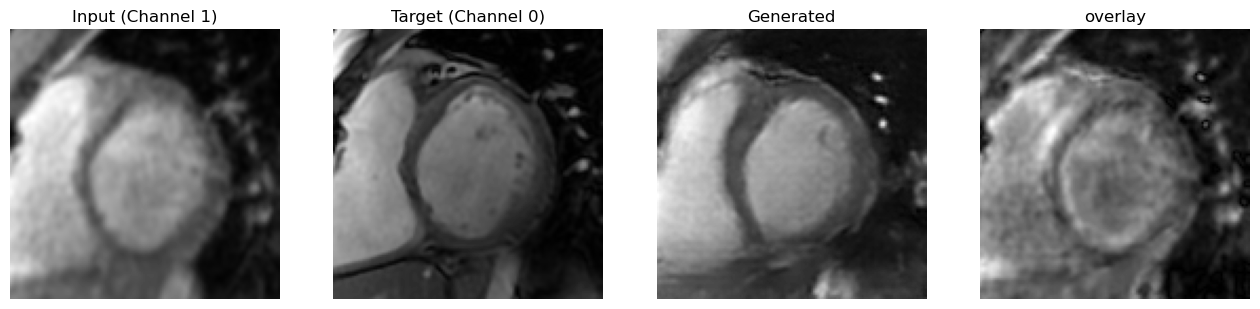

In [33]:
# 🖼️ 8. Visualize Sample Prediction
def display_sample(input_image, target):
    prediction = generator(tf.expand_dims(input_image, 0), training=False)[0]
    plt.figure(figsize=(16, 4))
    titles = ['Input (Channel 1)', 'Target (Channel 0)', 'Generated', 'Overlay']
    for i, img in enumerate([input_image, target, prediction]):
        if i == 0:
            img = img[:,:,0,:]
        plt.subplot(1, 4, i+1)
        plt.imshow(img[..., 0], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.subplot(1,4,4)
#     plt.imshow(input_image[:,:,0], cmap='PRGn', alpha=0.4)
#     plt.imshow(prediction[:,:,0], cmap='gray', alpha=0.6)
    plt.imshow(np.abs(input_image[:,:,0,0]-prediction[:,:,0]), cmap='gray')
    plt.title('overlay')
    plt.axis('off')
    plt.show()

# Run on a validation sample
sample = valid_data[115]
input_sample = np.concatenate([sample[64:-64,64:-64, 1:2], sample[64:-64,64:-64, 5:8]], axis=-1)
target_sample = sample[64:-64,64:-64, 0]
display_sample(input_sample[..., np.newaxis], target_sample[..., np.newaxis])

In [40]:
"""
Run Inference
"""

import os
import re

checkpoint_dir = "checkpoints_mag2ssfp_pix2pix"
model_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("generator_best_composite_epoch")]

# Extract epoch numbers correctly
def extract_epoch(filename):
    match = re.search(r'epoch_(\d+)', filename)
    return int(match.group(1)) if match else -1  # default -1 if no match

# Sort and get the latest
latest_model = sorted(model_files, key=extract_epoch)[-1]

generator = tf.keras.models.load_model(os.path.join(checkpoint_dir, latest_model))
print(f"✅ Loaded best generator from {latest_model}")

import matplotlib.pyplot as plt
import tensorflow as tf
import os

import csv

def generate_and_save_all(generator, dataset, seg_model, out_dir='test_results'):
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, "results.csv")

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Sample", "Dice", "SSIM"])

        sample_idx = 0
        dice_scores = []
        ssim_scores = []

        for i, (input_image, target) in enumerate(dataset):
            mag_only = input_image[..., :1]
            prediction = generator(input_image, training=False)

            # Run all images through the frozen segmentation model
            seg_input = seg_model(mag_only, training=False)
            seg_target = seg_model(target, training=False)
            seg_pred = seg_model(prediction, training=False)

            # Extract from dicts if needed
            if isinstance(seg_input, dict):   seg_input = list(seg_input.values())[0]
            if isinstance(seg_pred, dict):   seg_pred = list(seg_pred.values())[0]
            if isinstance(seg_target, dict): seg_target = list(seg_target.values())[0]

            batch_size = input_image.shape[0]
            for j in range(batch_size):
                # Plot and save visualization
                fig, ax = plt.subplots(2, 3, figsize=(12, 6))
                imgs = [mag_only[j], prediction[j], target[j]]
                segs = [seg_input[j], seg_pred[j], seg_target[j]]
                titles = ["Input (Ch.1)", "Generated", "Target (Ch.0)"]
                seg_titles = ["Seg(Input)", "Seg(Generated)", "Seg(Target)"]

                for k in range(3):
                    ax[0, k].imshow(tf.cast(tf.squeeze(imgs[k]), dtype=tf.float32), cmap='gray')
                    ax[0, k].set_title(titles[k])
                    ax[0, k].axis('off')

                    ax[1, k].imshow(tf.cast(tf.squeeze(segs[k]), dtype=tf.float32), cmap='gray')
                    ax[1, k].set_title(seg_titles[k])
                    ax[1, k].axis('off')

                plt.tight_layout()
                filename = f"sample_{sample_idx}.png"
                plt.savefig(os.path.join(out_dir, filename))
                plt.close()

                # Compute Dice
                pred_flat = tf.reshape(seg_pred[j], [-1])
                target_flat = tf.reshape(seg_target[j], [-1])
                intersection = tf.reduce_sum(pred_flat * target_flat)
                denominator = tf.reduce_sum(pred_flat) + tf.reduce_sum(target_flat)
                dice = (2. * intersection + 1e-6) / (denominator + 1e-6)

                # Compute SSIM
                ssim = tf.image.ssim(tf.expand_dims(prediction[j], 0),
                                     tf.expand_dims(target[j], 0),
                                     max_val=2.0)  # [-1, 1] range

                # Write to CSV
                writer.writerow([filename, float(dice), float(ssim)])
                dice_scores.append(float(dice))
                ssim_scores.append(float(ssim))
                sample_idx += 1
                print(f"🖼️ Saved {filename} | Dice: {dice:.4f} | SSIM: {ssim[0]:.4f}")

        # Summary row
        writer.writerow([])
        writer.writerow(["Average", f"{np.mean(dice_scores):.4f}", f"{np.mean(ssim_scores):.4f}"])
        print(f"\n📈 Saved CSV summary to {csv_path}")
            
test_dataset = get_dataset(test_data, shuffle=False)
generate_and_save_all(generator, test_dataset, seg_unet, out_dir="test_results")

✅ Loaded best generator from generator_best_composite_epoch_111.h5
🖼️ Saved sample_0.png | Dice: 0.8843 | SSIM: 0.7705
🖼️ Saved sample_1.png | Dice: 0.8740 | SSIM: 0.7639
🖼️ Saved sample_2.png | Dice: 0.8618 | SSIM: 0.7415
🖼️ Saved sample_3.png | Dice: 0.8486 | SSIM: 0.7126
🖼️ Saved sample_4.png | Dice: 0.7905 | SSIM: 0.7079
🖼️ Saved sample_5.png | Dice: 0.7812 | SSIM: 0.7133
🖼️ Saved sample_6.png | Dice: 0.7891 | SSIM: 0.7122
🖼️ Saved sample_7.png | Dice: 0.7974 | SSIM: 0.7190
🖼️ Saved sample_8.png | Dice: 0.8096 | SSIM: 0.7225
🖼️ Saved sample_9.png | Dice: 0.7686 | SSIM: 0.7218
🖼️ Saved sample_10.png | Dice: 0.7539 | SSIM: 0.7230
🖼️ Saved sample_11.png | Dice: 0.7935 | SSIM: 0.7272
🖼️ Saved sample_12.png | Dice: 0.8496 | SSIM: 0.7303
🖼️ Saved sample_13.png | Dice: 0.8994 | SSIM: 0.7316
🖼️ Saved sample_14.png | Dice: 0.8911 | SSIM: 0.7281
🖼️ Saved sample_15.png | Dice: 0.8950 | SSIM: 0.7436
🖼️ Saved sample_16.png | Dice: 0.8911 | SSIM: 0.7488
🖼️ Saved sample_17.png | Dice: 0.8887 | SS

🖼️ Saved sample_148.png | Dice: 0.8228 | SSIM: 0.6571
🖼️ Saved sample_149.png | Dice: 0.8018 | SSIM: 0.6642
🖼️ Saved sample_150.png | Dice: 0.8022 | SSIM: 0.6597
🖼️ Saved sample_151.png | Dice: 0.8486 | SSIM: 0.6601
🖼️ Saved sample_152.png | Dice: 0.8418 | SSIM: 0.6606
🖼️ Saved sample_153.png | Dice: 0.8555 | SSIM: 0.6690
🖼️ Saved sample_154.png | Dice: 0.8750 | SSIM: 0.6690
🖼️ Saved sample_155.png | Dice: 0.8687 | SSIM: 0.6552
🖼️ Saved sample_156.png | Dice: 0.8750 | SSIM: 0.6561
🖼️ Saved sample_157.png | Dice: 0.8589 | SSIM: 0.6664
🖼️ Saved sample_158.png | Dice: 0.8472 | SSIM: 0.6728
🖼️ Saved sample_159.png | Dice: 0.8584 | SSIM: 0.6718
🖼️ Saved sample_160.png | Dice: 0.8213 | SSIM: 0.7063
🖼️ Saved sample_161.png | Dice: 0.8008 | SSIM: 0.7007
🖼️ Saved sample_162.png | Dice: 0.7544 | SSIM: 0.6904
🖼️ Saved sample_163.png | Dice: 0.7119 | SSIM: 0.6828
🖼️ Saved sample_164.png | Dice: 0.7134 | SSIM: 0.6746
🖼️ Saved sample_165.png | Dice: 0.7568 | SSIM: 0.6658
🖼️ Saved sample_166.png | Di

🖼️ Saved sample_297.png | Dice: 0.9458 | SSIM: 0.8630
🖼️ Saved sample_298.png | Dice: 0.9424 | SSIM: 0.8629
🖼️ Saved sample_299.png | Dice: 0.9507 | SSIM: 0.8576
🖼️ Saved sample_300.png | Dice: 0.8169 | SSIM: 0.5057
🖼️ Saved sample_301.png | Dice: 0.7930 | SSIM: 0.4857
🖼️ Saved sample_302.png | Dice: 0.8188 | SSIM: 0.4812
🖼️ Saved sample_303.png | Dice: 0.7749 | SSIM: 0.4781
🖼️ Saved sample_304.png | Dice: 0.7505 | SSIM: 0.4536
🖼️ Saved sample_305.png | Dice: 0.7520 | SSIM: 0.4305
🖼️ Saved sample_306.png | Dice: 0.7314 | SSIM: 0.4393
🖼️ Saved sample_307.png | Dice: 0.6631 | SSIM: 0.4123
🖼️ Saved sample_308.png | Dice: 0.6436 | SSIM: 0.4402
🖼️ Saved sample_309.png | Dice: 0.7617 | SSIM: 0.4715
🖼️ Saved sample_310.png | Dice: 0.8340 | SSIM: 0.4707
🖼️ Saved sample_311.png | Dice: 0.8364 | SSIM: 0.4830
🖼️ Saved sample_312.png | Dice: 0.8311 | SSIM: 0.4681
🖼️ Saved sample_313.png | Dice: 0.8291 | SSIM: 0.4443
🖼️ Saved sample_314.png | Dice: 0.8633 | SSIM: 0.4728
🖼️ Saved sample_315.png | Di

🖼️ Saved sample_446.png | Dice: 0.8384 | SSIM: 0.5819
🖼️ Saved sample_447.png | Dice: 0.8481 | SSIM: 0.5802
🖼️ Saved sample_448.png | Dice: 0.8408 | SSIM: 0.5756
🖼️ Saved sample_449.png | Dice: 0.7705 | SSIM: 0.5752
🖼️ Saved sample_450.png | Dice: 0.7109 | SSIM: 0.5870
🖼️ Saved sample_451.png | Dice: 0.7666 | SSIM: 0.5916
🖼️ Saved sample_452.png | Dice: 0.8013 | SSIM: 0.5880
🖼️ Saved sample_453.png | Dice: 0.7729 | SSIM: 0.5832
🖼️ Saved sample_454.png | Dice: 0.7710 | SSIM: 0.5918
🖼️ Saved sample_455.png | Dice: 0.7852 | SSIM: 0.6034
🖼️ Saved sample_456.png | Dice: 0.8022 | SSIM: 0.5935
🖼️ Saved sample_457.png | Dice: 0.8013 | SSIM: 0.5927
🖼️ Saved sample_458.png | Dice: 0.8164 | SSIM: 0.5939
🖼️ Saved sample_459.png | Dice: 0.8364 | SSIM: 0.6095
🖼️ Saved sample_460.png | Dice: 0.7710 | SSIM: 0.6221
🖼️ Saved sample_461.png | Dice: 0.7295 | SSIM: 0.6188
🖼️ Saved sample_462.png | Dice: 0.7212 | SSIM: 0.6167
🖼️ Saved sample_463.png | Dice: 0.7397 | SSIM: 0.6168
🖼️ Saved sample_464.png | Di

🖼️ Saved sample_595.png | Dice: 0.9507 | SSIM: 0.6269
🖼️ Saved sample_596.png | Dice: 0.9453 | SSIM: 0.6253
🖼️ Saved sample_597.png | Dice: 0.9424 | SSIM: 0.6228
🖼️ Saved sample_598.png | Dice: 0.9282 | SSIM: 0.6438
🖼️ Saved sample_599.png | Dice: 0.9141 | SSIM: 0.6554
🖼️ Saved sample_600.png | Dice: 0.9429 | SSIM: 0.8283
🖼️ Saved sample_601.png | Dice: 0.9604 | SSIM: 0.8330
🖼️ Saved sample_602.png | Dice: 0.9565 | SSIM: 0.8356
🖼️ Saved sample_603.png | Dice: 0.9478 | SSIM: 0.8209
🖼️ Saved sample_604.png | Dice: 0.9302 | SSIM: 0.8150
🖼️ Saved sample_605.png | Dice: 0.9141 | SSIM: 0.8161
🖼️ Saved sample_606.png | Dice: 0.9155 | SSIM: 0.8171
🖼️ Saved sample_607.png | Dice: 0.9209 | SSIM: 0.8305
🖼️ Saved sample_608.png | Dice: 0.9194 | SSIM: 0.8363
🖼️ Saved sample_609.png | Dice: 0.9141 | SSIM: 0.8360
🖼️ Saved sample_610.png | Dice: 0.9531 | SSIM: 0.8432
🖼️ Saved sample_611.png | Dice: 0.9556 | SSIM: 0.8465
🖼️ Saved sample_612.png | Dice: 0.9551 | SSIM: 0.8425
🖼️ Saved sample_613.png | Di

🖼️ Saved sample_744.png | Dice: 0.9155 | SSIM: 0.7721
🖼️ Saved sample_745.png | Dice: 0.9194 | SSIM: 0.7680
🖼️ Saved sample_746.png | Dice: 0.9106 | SSIM: 0.7402
🖼️ Saved sample_747.png | Dice: 0.9146 | SSIM: 0.7627
🖼️ Saved sample_748.png | Dice: 0.9141 | SSIM: 0.7761
🖼️ Saved sample_749.png | Dice: 0.9102 | SSIM: 0.7944
🖼️ Saved sample_750.png | Dice: 0.9209 | SSIM: 0.8151
🖼️ Saved sample_751.png | Dice: 0.9268 | SSIM: 0.8149
🖼️ Saved sample_752.png | Dice: 0.9341 | SSIM: 0.8149
🖼️ Saved sample_753.png | Dice: 0.9258 | SSIM: 0.7992
🖼️ Saved sample_754.png | Dice: 0.9409 | SSIM: 0.7864
🖼️ Saved sample_755.png | Dice: 0.9395 | SSIM: 0.7730
🖼️ Saved sample_756.png | Dice: 0.9478 | SSIM: 0.7670
🖼️ Saved sample_757.png | Dice: 0.9521 | SSIM: 0.7822
🖼️ Saved sample_758.png | Dice: 0.9424 | SSIM: 0.8069
🖼️ Saved sample_759.png | Dice: 0.9517 | SSIM: 0.8260
🖼️ Saved sample_760.png | Dice: 0.9531 | SSIM: 0.6850
🖼️ Saved sample_761.png | Dice: 0.9639 | SSIM: 0.7018
🖼️ Saved sample_762.png | Di

🖼️ Saved sample_893.png | Dice: 0.9512 | SSIM: 0.5732
🖼️ Saved sample_894.png | Dice: 0.9570 | SSIM: 0.5875
🖼️ Saved sample_895.png | Dice: 0.9492 | SSIM: 0.5886
🖼️ Saved sample_896.png | Dice: 0.9512 | SSIM: 0.5891
🖼️ Saved sample_897.png | Dice: 0.9258 | SSIM: 0.5911
🖼️ Saved sample_898.png | Dice: 0.9282 | SSIM: 0.5786
🖼️ Saved sample_899.png | Dice: 0.9458 | SSIM: 0.5754
🖼️ Saved sample_900.png | Dice: 0.7808 | SSIM: 0.7198
🖼️ Saved sample_901.png | Dice: 0.7505 | SSIM: 0.7114
🖼️ Saved sample_902.png | Dice: 0.6855 | SSIM: 0.6793
🖼️ Saved sample_903.png | Dice: 0.6880 | SSIM: 0.6855
🖼️ Saved sample_904.png | Dice: 0.7148 | SSIM: 0.7024
🖼️ Saved sample_905.png | Dice: 0.7241 | SSIM: 0.6995
🖼️ Saved sample_906.png | Dice: 0.7158 | SSIM: 0.6967
🖼️ Saved sample_907.png | Dice: 0.7231 | SSIM: 0.7005
🖼️ Saved sample_908.png | Dice: 0.7271 | SSIM: 0.6939
🖼️ Saved sample_909.png | Dice: 0.6987 | SSIM: 0.7035
🖼️ Saved sample_910.png | Dice: 0.7915 | SSIM: 0.7256
🖼️ Saved sample_911.png | Di